In [1]:
# Load data from the Streaking Preprocessing .h5 file
# Last ran 07/17/2025

In [2]:
import os
import sys
sys.path.append('/sdf/data/lcls/ds/ued_testfac/scratch/python_packages')
import time
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import configparser
import argparse
import scipy.ndimage.measurements as smt

from scipy.ndimage import gaussian_filter as gf
from scipy.optimize import curve_fit
from scipy.special import erf
from psana import DataSource
from numba import jit, njit
from ued_LCLSII_DAQ_utilities import *
from UEDePixTools import *
from tqdm import tqdm
from PIL import Image

In [3]:
# Define the function with two Gaussians
def center_of_mass(Distribution,opetor): # Define Center of Mass function 
    output = np.sum(opetor*Distribution,axis=0)/np.sum(Distribution,axis=0)
    return output
 
def gaussian(x, amp, mean, sigma): # Define the Gaussian function
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def error_function(x, a, b, c,y0): # Define the error function model
    return a * erf(b * (x - c))+y0

In [4]:
# Check available files and print out keys from one of them
exp = 'run'
run = 26

# Check main run file
print("Keys in main run file:")
with h5py.File("/sdf/group/rfar/timodo/ePixdata/%s_%d.h5" % (exp, run), 'r') as raw:
    for i_key in raw.keys():
        print(i_key)

print("\nKeys in part0 file:")
# Check part0 file
with h5py.File("/sdf/group/rfar/timodo/ePixdata/%s_%d_part0.h5" % (exp, run), 'r') as raw:
    for i_key in raw.keys():
        print(i_key)

Keys in main run file:
img_com_1
img_com_2
img_cut
img_inte_1
img_inte_2
step_value
timestamp

Keys in part0 file:
img_com_1
img_com_2
img_cut
img_inte_1
img_inte_2
step_value
timestamp


In [5]:
runs = np.array([run])
print('Loading .h5 files for run(s):', runs)
tic = time.time()

# Dictionaries to store data for each run and file type
main_data = {}
part0_data = {}

for run in runs:
    print(f'Loading run: {run}')

    # --- Load main file ---
    main_path = f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}.h5"
    with h5py.File(main_path, 'r') as hf_main:
        print(f'  Loading main file: {exp}_{run}.h5')
        timestamp = np.argsort(np.array(hf_main.get('timestamp')))
        main_data[run] = {
            'shot_id': np.arange(0, len(timestamp))[timestamp],
            'scan_var_1': np.array(hf_main.get('step_value'))[timestamp].flatten(),
            'img_inte_1': np.array(hf_main.get('img_inte_1'))[timestamp],
            'img_inte_2': np.array(hf_main.get('img_inte_2'))[timestamp],
            'img_com_1': np.array(hf_main.get('img_com_1'))[timestamp],
            'img_com_2': np.array(hf_main.get('img_com_2'))[timestamp],
            'img_cut': np.array(hf_main.get('img_cut'))[timestamp]
        }
        print(f'    Main file shots: {len(main_data[run]["shot_id"])}')

    # --- Load part0 file ---
    part0_path = f"/sdf/group/rfar/timodo/ePixdata/{exp}_{run}_part0.h5"
    with h5py.File(part0_path, 'r') as hf_part:
        print(f'  Loading part0 file: {exp}_{run}_part0.h5')
        timestamp = np.argsort(np.array(hf_part.get('timestamp')))
        part0_data[run] = {
            'shot_id': np.arange(0, len(timestamp))[timestamp],
            'scan_var_1': np.array(hf_part.get('step_value'))[timestamp].flatten(),
            'img_inte_1': np.array(hf_part.get('img_inte_1'))[timestamp],
            'img_inte_2': np.array(hf_part.get('img_inte_2'))[timestamp],
            'img_com_1': np.array(hf_part.get('img_com_1'))[timestamp],
            'img_com_2': np.array(hf_part.get('img_com_2'))[timestamp],
            'img_cut': np.array(hf_part.get('img_cut'))[timestamp]
        }
        print(f'    Part0 file shots: {len(part0_data[run]["shot_id"])}')

toc = time.time()
print(f'Load time: {np.round(toc-tic)} seconds')

# --- Summaries for each run ---
for run in runs:
    # Main file summary
    delayss_main = np.unique(main_data[run]['scan_var_1'])
    print(f'Run {run} main file: {delayss_main.shape[0]} PV steps, {len(main_data[run]["shot_id"])} shots')
    print(f'  Image cut shape: {main_data[run]["img_cut"].shape}')

    # Part0 file summary
    delayss_part = np.unique(part0_data[run]['scan_var_1'])
    print(f'Run {run} part0 file: {delayss_part.shape[0]} PV steps, {len(part0_data[run]["shot_id"])} shots')
    print(f'  Image cut shape: {part0_data[run]["img_cut"].shape}')

Loading .h5 files for run(s): [26]
Loading run: 26
  Loading main file: run_26.h5
    Main file shots: 950
  Loading part0 file: run_26_part0.h5
    Part0 file shots: 950
Load time: 0.0 seconds
Run 26 main file: 38 PV steps, 950 shots
  Image cut shape: (950, 65, 28)
Run 26 part0 file: 38 PV steps, 950 shots
  Image cut shape: (950, 65, 28)


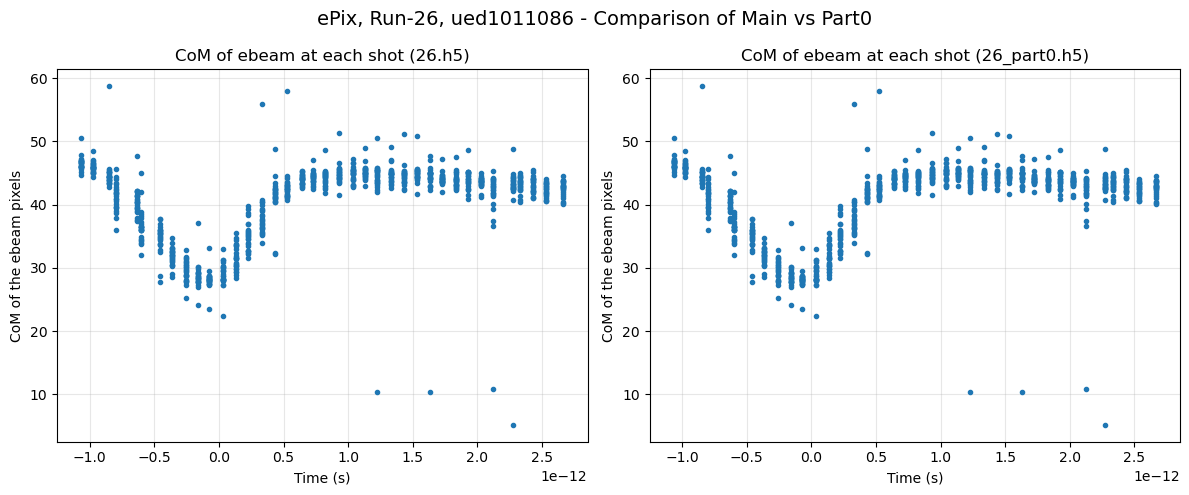

In [6]:
C = 3e8  # Speed of light in m/s

# Choose the run (assuming a single run was loaded)
run = runs[0]

# Extract arrays from your dictionaries
img_com_2_main = main_data[run]['img_com_2']
scan_var_1_main = main_data[run]['scan_var_1']
img_com_2_part = part0_data[run]['img_com_2']
scan_var_1_part = part0_data[run]['scan_var_1']

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Compute mask
main_mask = (img_com_2_main > 5) & (img_com_2_main < 60)
part_mask = (img_com_2_part > 5) & (img_com_2_part < 60)

# Rescale scan variable to time (x-axis) for main and part0
t_main = 2 * (scan_var_1_main[main_mask] - 212.8) / (1000 * C)
t_part = 2 * (scan_var_1_part[part_mask] - 212.8) / (1000 * C)

# Main run plot
plt.subplot(1, 2, 1)
plt.plot(t_main, img_com_2_main[main_mask], '.')
plt.xlabel('Time (s)')
plt.ylabel('CoM of the ebeam pixels')
plt.title(f'CoM of ebeam at each shot ({run}.h5)')
plt.grid(True, alpha=0.3)

# Part0 run plot
plt.subplot(1, 2, 2)
plt.plot(t_part, img_com_2_part[part_mask], '.')
plt.xlabel('Time (s)')
plt.ylabel('CoM of the ebeam pixels')
plt.title(f'CoM of ebeam at each shot ({run}_part0.h5)')
plt.grid(True, alpha=0.3)

plt.suptitle(f'ePix, Run-{run}, ued1011086 - Comparison of Main vs Part0', fontsize=14)
plt.tight_layout()
plt.show()

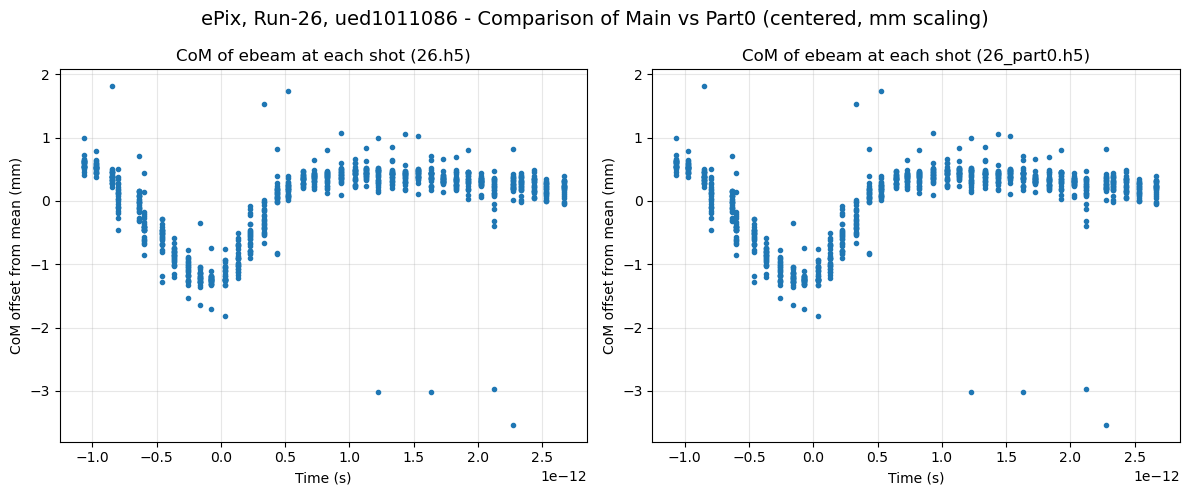

In [7]:
C = 3e8  # Speed of light in m/s

# Choose the run (assuming a single run was loaded)
run = runs[0]

# Extract arrays from your dictionaries
img_com_2_main = main_data[run]['img_com_2']
scan_var_1_main = main_data[run]['scan_var_1']
img_com_2_part = part0_data[run]['img_com_2']
scan_var_1_part = part0_data[run]['scan_var_1']

plt.figure(figsize=(12, 5))

# Compute mask
main_mask = (img_com_2_main > 5) & (img_com_2_main < 60)
part_mask = (img_com_2_part > 5) & (img_com_2_part < 60)

# Rescale scan variable to time (x-axis) for main and part0
t_main = 2 * (scan_var_1_main[main_mask] - 212.8) / (1000 * C)
t_part = 2 * (scan_var_1_part[part_mask] - 212.8) / (1000 * C)

# Center and scale CoM values to 100 micrometers
img_com_main_masked = img_com_2_main[main_mask]
img_com_part_masked = img_com_2_part[part_mask]

avg_main = np.mean(img_com_main_masked)
avg_part = np.mean(img_com_part_masked)

img_com_2_main_100um_centered = (img_com_main_masked - avg_main) * 100e-6 * 1000
img_com_2_part_100um_centered = (img_com_part_masked - avg_part) * 100e-6 * 1000

# Main run plot
plt.subplot(1, 2, 1)
plt.plot(t_main, img_com_2_main_100um_centered, '.')
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title(f'CoM of ebeam at each shot ({run}.h5)')
plt.grid(True, alpha=0.3)

# Part0 run plot
plt.subplot(1, 2, 2)
plt.plot(t_part, img_com_2_part_100um_centered, '.')
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title(f'CoM of ebeam at each shot ({run}_part0.h5)')
plt.grid(True, alpha=0.3)

plt.suptitle(f'ePix, Run-{run}, ued1011086 - Comparison of Main vs Part0 (centered, mm scaling)', fontsize=14)
plt.tight_layout()
plt.show()

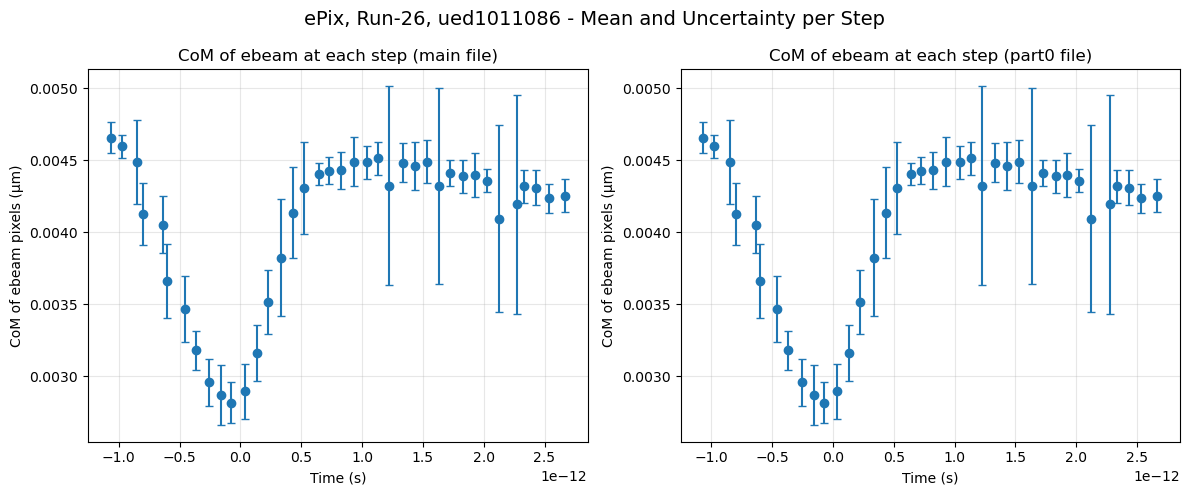

In [8]:
C = 3e8  # Speed of light in m/s

# Choose the run (assuming a single run as before)
run = runs[0]

# Extract arrays from the dictionaries
img_com_2_main_runs = main_data[run]['img_com_2']
scan_var_1_main_runs = main_data[run]['scan_var_1']
img_com_2_part_runs = part0_data[run]['img_com_2']
scan_var_1_part_runs = part0_data[run]['scan_var_1']

# Masks as used previously
main_mask = (img_com_2_main_runs > 5) & (img_com_2_main_runs < 60)
part_mask = (img_com_2_part_runs > 5) & (img_com_2_part_runs < 60)

# Get unique scan steps
unique_steps_main = np.unique(scan_var_1_main_runs)
unique_steps_part = np.unique(scan_var_1_part_runs)

# Compute mean, std, and time for each scan step (MAIN)
mean_main = []
std_main = []
time_main = []
for step in unique_steps_main:
    mask = (scan_var_1_main_runs == step) & main_mask
    vals = img_com_2_main_runs[mask]
    if len(vals) > 0:
        mean_main.append(np.mean(vals) * 100e-6)
        std_main.append(np.std(vals) * 100e-6)
        time_main.append(2 * (step - 212.8) / (1000 * C))
mean_main = np.array(mean_main)
std_main = np.array(std_main)
time_main = np.array(time_main)

# Compute mean, std, and time for each scan step (PART0)
mean_part = []
std_part = []
time_part = []
for step in unique_steps_part:
    mask = (scan_var_1_part_runs == step) & part_mask
    vals = img_com_2_part_runs[mask]
    if len(vals) > 0:
        mean_part.append(np.mean(vals) * 100e-6)
        std_part.append(np.std(vals) * 100e-6)
        time_part.append(2 * (step - 212.8) / (1000 * C))
mean_part = np.array(mean_part)
std_part = np.array(std_part)
time_part = np.array(time_part)

# Plotting: error bars with unconnected dots
plt.figure(figsize=(12, 5))

# Main run errorbar plot
plt.subplot(1, 2, 1)
plt.errorbar(time_main, mean_main, yerr=std_main, fmt='o', capsize=3)
plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam pixels (μm)')
plt.title('CoM of ebeam at each step (main file)')
plt.grid(True, alpha=0.3)

# Part0 run errorbar plot
plt.subplot(1, 2, 2)
plt.errorbar(time_part, mean_part, yerr=std_part, fmt='o', capsize=3)
plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam pixels (μm)')
plt.title('CoM of ebeam at each step (part0 file)')
plt.grid(True, alpha=0.3)

plt.suptitle(f'ePix, Run-{run}, ued1011086 - Mean and Uncertainty per Step', fontsize=14)
plt.tight_layout()
plt.show()

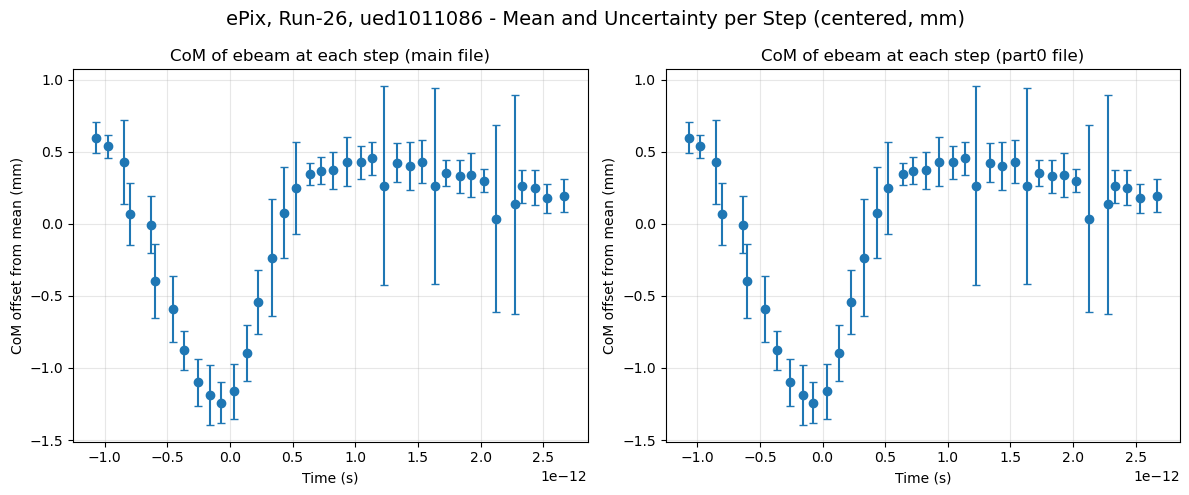

In [9]:
C = 3e8  # Speed of light in m/s

# Choose the run (assuming a single run as before)
run = runs[0]

# Extract arrays from the dictionaries
img_com_2_main_runs = main_data[run]['img_com_2']
scan_var_1_main_runs = main_data[run]['scan_var_1']
img_com_2_part_runs = part0_data[run]['img_com_2']
scan_var_1_part_runs = part0_data[run]['scan_var_1']

# Masks as used previously
main_mask = (img_com_2_main_runs > 5) & (img_com_2_main_runs < 60)
part_mask = (img_com_2_part_runs > 5) & (img_com_2_part_runs < 60)

# Compute overall mean after masking for centering
avg_main = np.mean(img_com_2_main_runs[main_mask])
avg_part = np.mean(img_com_2_part_runs[part_mask])

# Get unique scan steps
unique_steps_main = np.unique(scan_var_1_main_runs)
unique_steps_part = np.unique(scan_var_1_part_runs)

# Compute centered mean, std, and time for each scan step (MAIN)
mean_main = []
std_main = []
time_main = []
for step in unique_steps_main:
    mask = (scan_var_1_main_runs == step) & main_mask
    vals = img_com_2_main_runs[mask]
    if len(vals) > 0:
        mean_main.append((np.mean(vals) - avg_main) * 100e-6 * 1000)   # Center + scale to mm
        std_main.append(np.std(vals) * 100e-6 * 1000)                  # Std scaled to mm
        time_main.append(2 * (step - 212.8) / (1000 * C))
mean_main = np.array(mean_main)
std_main = np.array(std_main)
time_main = np.array(time_main)

# Compute centered mean, std, and time for each scan step (PART0)
mean_part = []
std_part = []
time_part = []
for step in unique_steps_part:
    mask = (scan_var_1_part_runs == step) & part_mask
    vals = img_com_2_part_runs[mask]
    if len(vals) > 0:
        mean_part.append((np.mean(vals) - avg_part) * 100e-6 * 1000)   # Center + scale to mm
        std_part.append(np.std(vals) * 100e-6 * 1000)                  # Std scaled to mm
        time_part.append(2 * (step - 212.8) / (1000 * C))
mean_part = np.array(mean_part)
std_part = np.array(std_part)
time_part = np.array(time_part)

# Plotting: error bars with unconnected dots
plt.figure(figsize=(12, 5))

# Main run errorbar plot
plt.subplot(1, 2, 1)
plt.errorbar(time_main, mean_main, yerr=std_main, fmt='o', capsize=3)
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title('CoM of ebeam at each step (main file)')
plt.grid(True, alpha=0.3)

# Part0 run errorbar plot
plt.subplot(1, 2, 2)
plt.errorbar(time_part, mean_part, yerr=std_part, fmt='o', capsize=3)
plt.xlabel('Time (s)')
plt.ylabel('CoM offset from mean (mm)')
plt.title('CoM of ebeam at each step (part0 file)')
plt.grid(True, alpha=0.3)

plt.suptitle(f'ePix, Run-{run}, ued1011086 - Mean and Uncertainty per Step (centered, mm)', fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Save part0 dataset to the desired directory
np.savez('/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_26.npz', t_part=t_part, img_com_2_part_100um=img_com_2_part_100um_centered)

In [11]:
# Select the active run (assuming a single run)
run = runs[0]

# Extract arrays from dictionaries
img_cut_main = main_data[run]['img_cut']
img_inte_2_main = main_data[run]['img_inte_2']
img_com_2_main = main_data[run]['img_com_2']
scan_var_1_main = main_data[run]['scan_var_1']

img_cut_part = part0_data[run]['img_cut']
img_inte_2_part = part0_data[run]['img_inte_2']
img_com_2_part = part0_data[run]['img_com_2']
scan_var_1_part = part0_data[run]['scan_var_1']

# Averaging for MAIN RUN
img_runs_ave_main = []
img_inte_2_runs_ave_main = []
img_inte_2_runs_coms_ave_main = []
delayss_main = np.unique(scan_var_1_main)

for i_delay, delay in enumerate(delayss_main):
    flt_step = (scan_var_1_main == delay) & (img_com_2_main > 0) & (img_com_2_main < 60)
    img_runs_ave_main.append(img_cut_main[flt_step].mean(axis=0))
    img_inte_2_runs_ave_main.append(img_inte_2_main[flt_step].mean(axis=0))  # average trace
    img_inte_2_runs_coms_ave_main.append(img_com_2_main[flt_step].mean())

img_inte_2_runs_coms_ave_main = np.array(img_inte_2_runs_coms_ave_main)
img_inte_2_runs_ave_main = np.array(img_inte_2_runs_ave_main)
img_runs_ave_main = np.array(img_runs_ave_main)

# Averaging for PART0 RUN
img_runs_ave_part = []
img_inte_2_runs_ave_part = []
img_inte_2_runs_coms_ave_part = []
delayss_part = np.unique(scan_var_1_part)

for i_delay, delay in enumerate(delayss_part):
    flt_step = (scan_var_1_part == delay) & (img_com_2_part > 0) & (img_com_2_part < 60)
    img_runs_ave_part.append(img_cut_part[flt_step].mean(axis=0))
    img_inte_2_runs_ave_part.append(img_inte_2_part[flt_step].mean(axis=0))  # average trace
    img_inte_2_runs_coms_ave_part.append(img_com_2_part[flt_step].mean())

img_inte_2_runs_coms_ave_part = np.array(img_inte_2_runs_coms_ave_part)
img_inte_2_runs_ave_part = np.array(img_inte_2_runs_ave_part)
img_runs_ave_part = np.array(img_runs_ave_part)

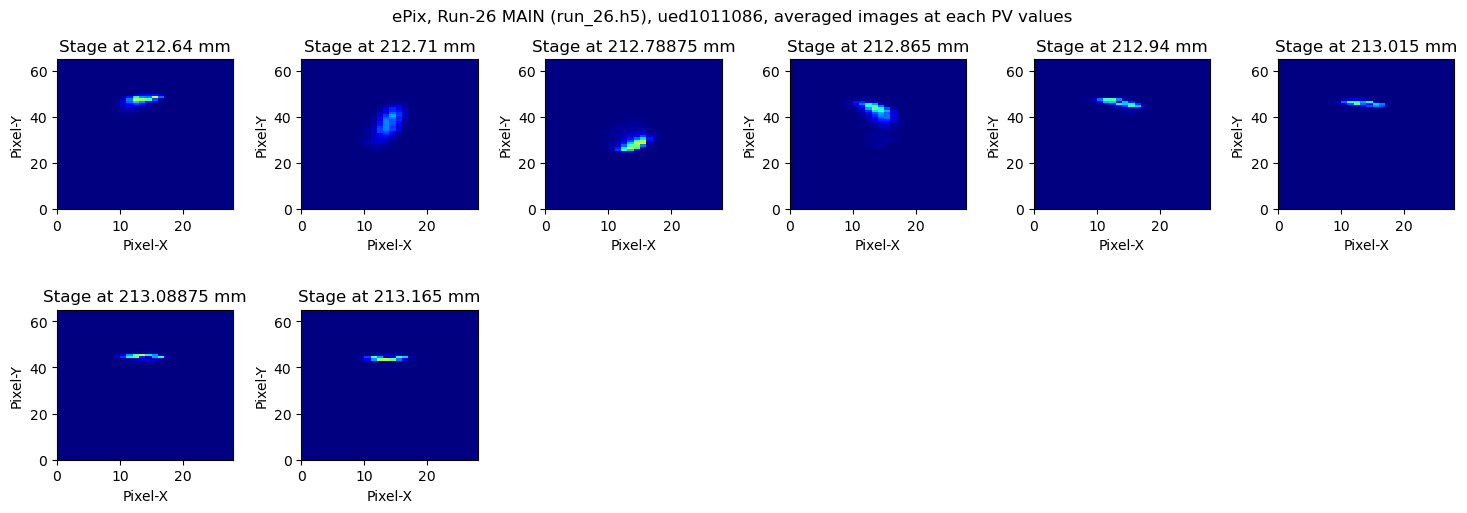

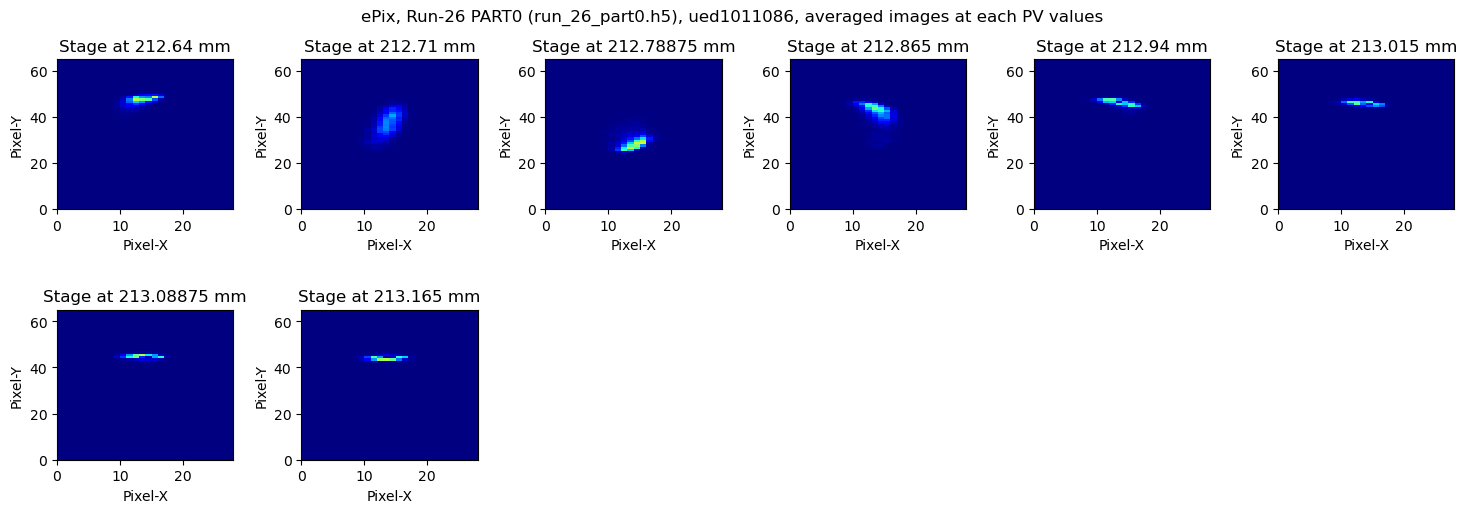

In [12]:
# MAIN run: only track available delays
img_runs_ave_main = []
delayss_main_available = []
for i_delay, delay in enumerate(delayss_main):
    flt_step = (scan_var_1_main == delay) & (img_com_2_main > 0) & (img_com_2_main < 60)
    if np.any(flt_step):
        img_runs_ave_main.append(img_cut_main[flt_step].mean(axis=0))
        delayss_main_available.append(delay)
img_runs_ave_main = np.array(img_runs_ave_main)

plt.figure(figsize=(15, 10))
plt.suptitle(f'ePix, Run-{run} MAIN (run_26.h5), ued1011086, averaged images at each PV values', y=0.98)
i_subplot = 1
for i_delay, delay in enumerate(delayss_main_available):
    if i_delay % 5 == 0:
        plt.subplot(4, 6, i_subplot)
        plt.pcolormesh(img_runs_ave_main[i_delay], cmap='jet')
        plt.clim([0, 70000])
        plt.xlabel('Pixel-X')
        plt.ylabel('Pixel-Y')
        plt.title(f'Stage at {delay} mm')
        i_subplot += 1

plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=1.5)
plt.subplots_adjust(top=0.93)
plt.show()

# PART0 run (repeat the same approach)
img_runs_ave_part = []
delayss_part_available = []
for i_delay, delay in enumerate(delayss_part):
    flt_step = (scan_var_1_part == delay) & (img_com_2_part > 0) & (img_com_2_part < 60)
    if np.any(flt_step):
        img_runs_ave_part.append(img_cut_part[flt_step].mean(axis=0))
        delayss_part_available.append(delay)
img_runs_ave_part = np.array(img_runs_ave_part)

plt.figure(figsize=(15, 10))
plt.suptitle(f'ePix, Run-{run} PART0 (run_26_part0.h5), ued1011086, averaged images at each PV values', y=0.98)
i_subplot = 1
for i_delay, delay in enumerate(delayss_part_available):
    if i_delay % 5 == 0:
        plt.subplot(4, 6, i_subplot)
        plt.pcolormesh(img_runs_ave_part[i_delay], cmap='jet')
        plt.clim([0, 70000])
        plt.xlabel('Pixel-X')
        plt.ylabel('Pixel-Y')
        plt.title(f'Stage at {delay} mm')
        i_subplot += 1

plt.tight_layout(pad=2.0, h_pad=2.5, w_pad=1.5)
plt.subplots_adjust(top=0.93)
plt.show()

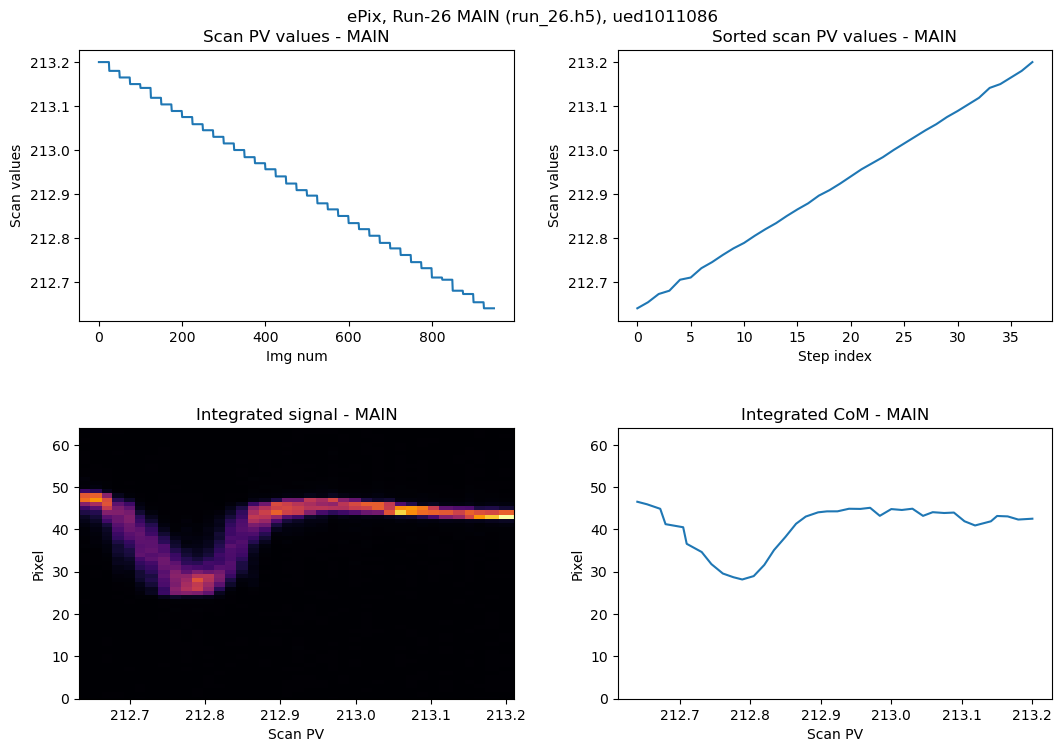

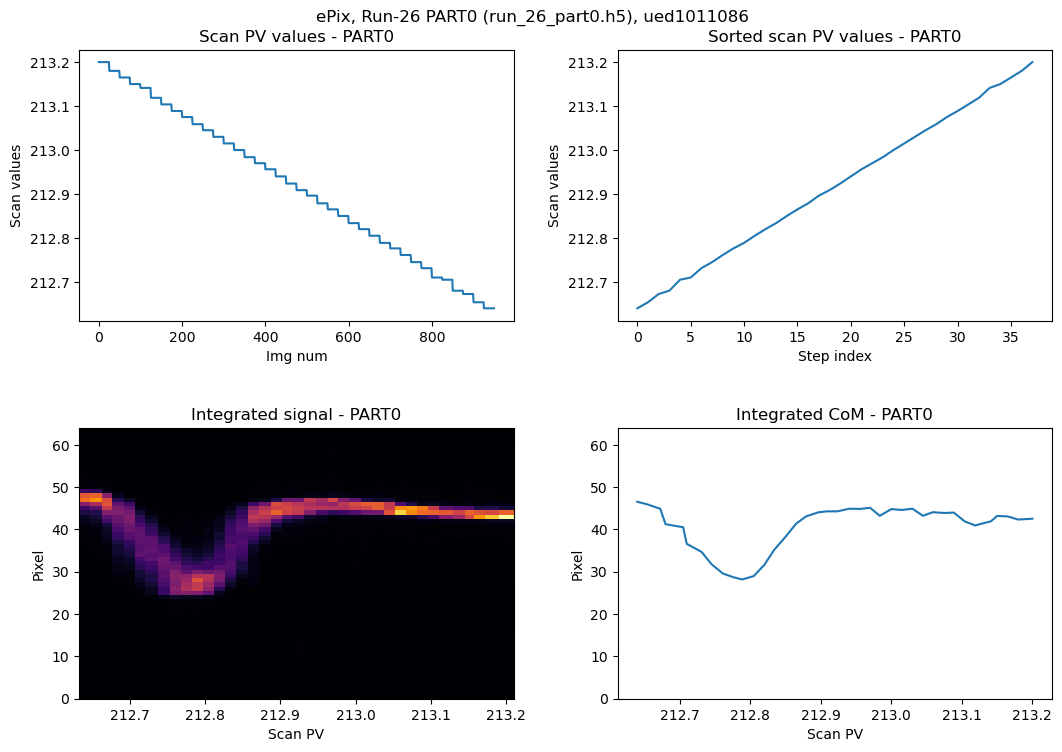

In [13]:
# Pick the loaded run (assuming one run)
run = runs[0]

# Extract data arrays from dictionaries
scan_var_1_main = main_data[run]['scan_var_1']
img_inte_2_main = main_data[run]['img_inte_2']
img_cut_main = main_data[run]['img_cut']

scan_var_1_part = part0_data[run]['scan_var_1']
img_inte_2_part = part0_data[run]['img_inte_2']
img_cut_part = part0_data[run]['img_cut']

# Your averaged arrays from previous steps should also be available:
# - delayss_main, img_inte_2_runs_ave_main, img_inte_2_runs_coms_ave_main
# - delayss_part, img_inte_2_runs_ave_part, img_inte_2_runs_coms_ave_part

# MAIN RUN - Summary plots
plt.figure(figsize=(11, 8))
plt.suptitle(f'ePix, Run-{run} MAIN (run_26.h5), ued1011086', y=0.95)

plt.subplot(2, 2, 1)
plt.plot(scan_var_1_main)
plt.xlabel('Img num')
plt.ylabel('Scan values')
plt.title('Scan PV values - MAIN')

plt.subplot(2, 2, 2)
plt.plot(delayss_main, '-')
plt.xlabel('Step index')
plt.ylabel('Scan values')
plt.title('Sorted scan PV values - MAIN')

plt.subplot(2, 2, 3)
plt.pcolormesh(
    delayss_main,
    np.arange(img_inte_2_runs_ave_main.shape[1]),
    img_inte_2_runs_ave_main.T,
    cmap='inferno'
)
plt.ylim([0, img_cut_main.shape[1] - 1])
plt.title('Integrated signal - MAIN')
plt.ylabel('Pixel')
plt.xlabel('Scan PV')

plt.subplot(2, 2, 4)
plt.plot(delayss_main, img_inte_2_runs_coms_ave_main)
plt.ylim([0, img_cut_main.shape[1] - 1])
plt.xlabel('Scan PV')
plt.ylabel('Pixel')
plt.title('Integrated CoM - MAIN')

plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.5)
plt.subplots_adjust(top=0.90)
plt.show()

# PART0 RUN - Summary plots
plt.figure(figsize=(11, 8))
plt.suptitle(f'ePix, Run-{run} PART0 (run_26_part0.h5), ued1011086', y=0.95)

plt.subplot(2, 2, 1)
plt.plot(scan_var_1_part)
plt.xlabel('Img num')
plt.ylabel('Scan values')
plt.title('Scan PV values - PART0')

plt.subplot(2, 2, 2)
plt.plot(delayss_part, '-')
plt.xlabel('Step index')
plt.ylabel('Scan values')
plt.title('Sorted scan PV values - PART0')

plt.subplot(2, 2, 3)
plt.pcolormesh(
    delayss_part,
    np.arange(img_inte_2_runs_ave_part.shape[1]),
    img_inte_2_runs_ave_part.T,
    cmap='inferno'
)
plt.ylim([0, img_cut_part.shape[1] - 1])
plt.title('Integrated signal - PART0')
plt.ylabel('Pixel')
plt.xlabel('Scan PV')

plt.subplot(2, 2, 4)
plt.plot(delayss_part, img_inte_2_runs_coms_ave_part)
plt.ylim([0, img_cut_part.shape[1] - 1])
plt.xlabel('Scan PV')
plt.ylabel('Pixel')
plt.title('Integrated CoM - PART0')

plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.5)
plt.subplots_adjust(top=0.90)
plt.show()